#### Sparisity Comparison version of RadixNet.ipynb
This program copies the RadiXNet implementation from RadixNet.ipynb, but instead uses it to create multiple networks with differing sparsities to compare the difference in accuracies between sparsities

## Imports

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pickle
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_model_optimization as tfmot
from RadixNetCalc import emr_net, kemr_net
import matlab.engine
import math
import networkx as nx

### Read data

In [3]:
data = pd.read_csv("MNIST/mnist_train.csv") #mnist train
test = pd.read_csv("MNIST/mnist_test.csv") #mnist test
data = np.array(data)
np.random.seed(100)
np.random.shuffle(data) 

data_train = data.T
Y_train = np.array(data_train[0])
X_train = np.array(data_train[1:]).T
X_train = X_train / 255

test = np.array(test)
data_test = test.T
Y_test = np.array(data_test[0])
X_test = np.array(data_test[1:]).T
X_test = X_test / 255

## Create a Mask 
Create using Mask(num_output, input_shape, radix), call using maskname()

In [4]:
class Mask(tf.Module):
    """
    A class used to create tensorflow masks that represent the RadiXNet weight masks. 
    They are used to be applied at every call of a RadixLayer, specifically at every step of training.
    ...
    Attributes
    ----------
    val : None or tf.Variable
        keeps track of what the mask is in a tensorflow format, kept as None to start with 
        but is changed the first time it's called
    layerval : np.array
        input of what the mask should be in a numpy array format.
    """
    def __init__(self,layerval:np.array):
        """
        Used to construct a Mask, but doesn't have the correct shape yet.
        Inputs:
        layerval : np.array
            input of what the mask should be in a numpy array format
        """
        self.val=None
        self.layerval = layerval
    @tf.function
    def __call__(self):
        """
        Used whenever you want to actually use the mask
        Example of usage:
            mask = Mask(layerval) #create the mask
            tf.math.multiply(kernel, mask()) #calling the mask
        """
        if self.val is None:
            #arr = np.zeros(self.input_shape[1:]+(self.num_outputs,))
            arr = self.layerval
            tensor = tf.constant(arr, dtype= tf.float32)
            self.val = tf.Variable(tensor)
        return self.val
        

### RadixLayer

In [5]:
class RadixLayer(layers.Layer):
    """
    A class used to create layers of a RadiXNet, made for an easier implementation of RadiXNets
    ...
    Attributes
    ----------
    num_outputs : int
        the number of outputs that the layer should have, or how many neurons are in the next layer
    layerval : numpy array
        input of what the mask should be in a numpy array format
    activation : function
        activation function used
    kernel : tensorflow Variable
        the values of the layer that will be trained
    """
    def __init__(self, num_outputs:int, layerval:np.array, activation = tf.nn.relu):
        """
        Used to construct a RadixLayer
        Inputs:
        num_outputs : int
            number of outputs that layer should have
        layerval : numpy array
            input of what the mask should be
        activation : function
            activation type, defaults to relu function
        """
        super(RadixLayer,self).__init__()
        self.num_outputs = num_outputs
        self.layerval = layerval
        self.activation = activation
    def build(self, input_shape:tuple):
        """
        Used when first creating and calling a RadixLayer, creates the kernel variable
        Inputs:
        input_shape : tuple
            Size of inputs, this is needed in the build function but is currently not used because our kernel 
            shapes should take on the shape of the radix layer
        """
        self.kernel = self.add_weight("kernel", shape = self.layerval.shape, initializer='random_normal', trainable=True)
    def call(self, inputs:tf.Tensor):
        """
        Used whenever the RadixLayer is called during iterations
        Inputs:
        inputs: tensor
            What will be going into the RadiXLayer
        Outputs:
            returns the inputs matrix multiplied with a masked version of the kernel (element wise multiplication between kernel and mask)
        """
        mask = Mask(self.layerval)
        masked = tf.math.multiply(self.kernel,mask())
        #extrazero =  tf.zeros(shape=(self.layerval.shape[0]-inputs.shape[1]), dtype=tf.int32)
        #inputs = tf.concat(inputs,extrazero)
        try:
            return self.activation(tf.matmul(inputs,masked))
        except:
            return None

# Create different models based on sparsity

In [6]:
desired = [784,300,100,10]
def calculate_sparsity(sparselayers):
    a = 0
    b = 0
    for layer in sparselayers:
        a += np.count_nonzero(layer)
        b += np.prod(layer.shape)
    return 1 - a/b

sparsemodels = dict()
greater90 = dict()
def findModels():
    N = [[],[]]
    for i in range(1,16):
        N[0].append(i)
        for j in range(1,16):
            N[0].append(j)
            B= []
            for num in desired:
                B.append(math.ceil(num/(i*j)))
            for k in range(1,i*j+1):
                for l in range(len(desired)-3):
                    N[1].append(k)
                #print(N,B)
                try:
                    curlayers = kemr_net(N,B)
                    model = ((tuple(N[0]),tuple(N[1])),tuple(B))
                    spars = calculate_sparsity(curlayers)
                    sparsemodels[spars] = model
                    if spars>=0.9:
                        greater90[spars] = model
                except:
                    pass
                N[1].clear()
            N[0].pop()
        N[0].pop()
findModels()
#print(sparsemodels)
def createModel(sparsity, model = None):
    curmodel = model
    if model==None:
        temp =min(sparsemodels.keys(), key=lambda x: abs(x - sparsity))
        curmodel = sparsemodels[temp]
    N = curmodel[0]
    B = curmodel[1]
    #print(N, B)
    desired = [784,300,100,10]
    rlayers = kemr_net(N,B)
    for i in range(len(rlayers)):
        if rlayers[i].shape[0]>desired[i]:
            rlayers[i] = rlayers[i][:desired[i],:]
        if rlayers[i].shape[1]>desired[i+1]:
            rlayers[i] = rlayers[i][:,:desired[i+1]]
    class CustomModel(tf.keras.Model):
        def __init__(self, rlayers:list):
            """
            Initialization of layers (choose how many layers you want)
            Inputs:
            rlayers : list of numpy arrays
                fully created rlayers from kemr_net and trimmed to fit desired
            """
            super(CustomModel,self).__init__()
            self.layer1 = RadixLayer(rlayers[0].shape[-1], rlayers[0],tf.nn.relu)
            self.layer2 = RadixLayer(rlayers[1].shape[-1],rlayers[1],tf.nn.relu)
            self.layer3 = RadixLayer(rlayers[2].shape[-1],rlayers[2],tf.nn.softmax)
        def call(self, input_tensor:tf.Tensor):
            """
            Actually does the math and calculates the result of an input through the network.
            Customize what activation functions are used
            Inputs:
            input_tensor : tensor
                the input
            Outputs:
                The result of the calculation
            """
            x= self.layer1(input_tensor)
            x= self.layer2(x)
            x= self.layer3(x)
            return x

    sparsity = calculate_sparsity(rlayers)
    #print("Sparsity: "+ str(sparsity))
    return CustomModel(rlayers)
createModel(0.5)

2023-08-01 17:07:46.720320: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-01 17:07:46.724935: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-01 17:07:46.724971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (d-5-3-1): /proc/driver/nvidia/version does not exist
2023-08-01 17:07:46.736151: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<__main__.createModel.<locals>.CustomModel at 0x7f8e08d80670>

### Model compilations

In [7]:
models = []
sparsities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for sparsity in sparsities:
    model = createModel(sparsity)
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    models.append(model)

### Training

In [7]:
histories = []
for i, model in enumerate(models):
    print("training model with sparsity "+str(sparsities[i]))
    epochs = 5
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = 100,validation_split = 0.1, verbose = 0)
    histories.append(history)

training model with sparsity 0.1
training model with sparsity 0.2
training model with sparsity 0.3
training model with sparsity 0.4
training model with sparsity 0.5
training model with sparsity 0.6
training model with sparsity 0.7
training model with sparsity 0.8
training model with sparsity 0.9


### Testing

In [8]:
accuracies = []
for model in models:
    accuracies.append(model.evaluate(X_test, Y_test)[1])

313/313 [==============================] - 0s 979us/step - loss: 0.2096 - accuracy: 0.9392


## Plotting accuracy vs. Sparsity

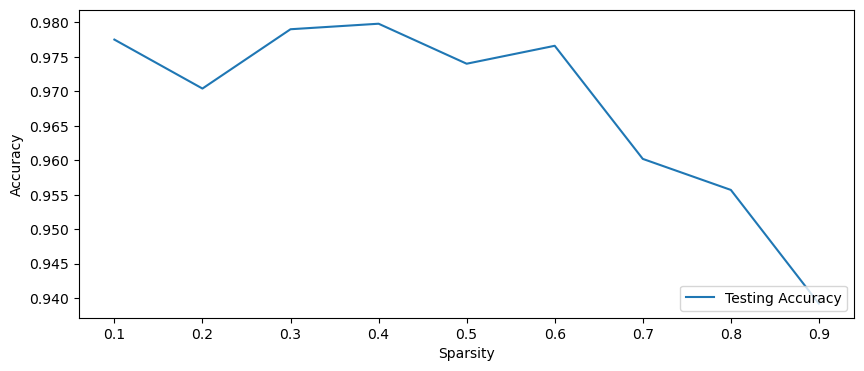

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(sparsities, accuracies, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.show()

### Plotting training accuracies

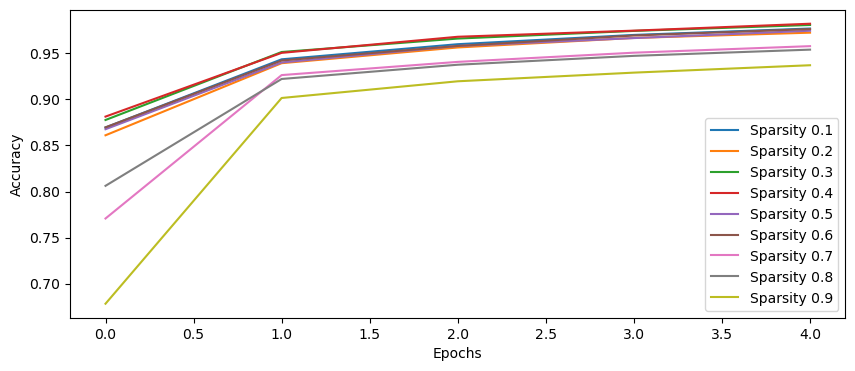

In [10]:
epochs_range = range(epochs)
plt.figure(figsize=(10, 4))
for i, history in enumerate(histories):
    acc = history.history['accuracy']
    
    plt.plot(epochs_range, acc, label='Sparsity '+str(sparsities[i]))
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
    
plt.show()

## >0.9 Sparsities only

In [30]:
myKeys = list(greater90.keys())
myKeys.sort()
#print(myKeys)
models = []
sampleSize = 20
sparsities = []
rstructures = []
for i in range(0,len(myKeys),len(myKeys)//20):
    sparsity = myKeys[i]
    sparsities.append(sparsity)
    rstructures.append(greater90[sparsity])
    model = createModel(sparsity,greater90[sparsity])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    models.append(model)
for i in range(len(sparsities)):
    print(str(sparsities[i])+": "+str(rstructures[i]))

0.9: (((15, 12), (60,)), (5, 2, 1, 1))
0.9021428571428571: (((10, 10), (4,)), (8, 3, 1, 1))
0.9038095238095238: (((7, 12), (14,)), (10, 4, 2, 1))
0.9051383399209486: (((8, 11), (4,)), (9, 4, 2, 1))
0.9064577397910731: (((6, 13), (13,)), (11, 4, 2, 1))
0.9081289081289081: (((9, 11), (3,)), (8, 4, 2, 1))
0.9101239669421488: (((12, 11), (12,)), (6, 3, 1, 1))
0.9115646258503401: (((7, 14), (14,)), (8, 4, 2, 1))
0.9126984126984127: (((9, 12), (12,)), (8, 3, 1, 1))
0.9146825396825397: (((9, 12), (6,)), (8, 3, 1, 1))
0.9156746031746031: (((9, 12), (3,)), (8, 3, 1, 1))
0.9175213675213675: (((13, 12), (13,)), (6, 2, 1, 1))
0.9190771349862259: (((11, 12), (1,)), (6, 3, 1, 1))
0.921: (((8, 15), (24,)), (7, 3, 1, 1))
0.9226495726495727: (((13, 12), (1,)), (6, 2, 1, 1))
0.9246753246753247: (((11, 14), (14,)), (6, 2, 1, 1))
0.9264957264957265: (((12, 13), (2,)), (6, 2, 1, 1))
0.9283333333333333: (((8, 15), (2,)), (7, 3, 1, 1))
0.9306666666666666: (((10, 15), (6,)), (6, 2, 1, 1))
0.9332096474953617: 

In [7]:
histories = []
for i, model in enumerate(models):
    print("model " +str(i+1)+" out of "+str(len(models)))
    epochs = 3
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = 100,validation_split = 0.1, verbose = 0)
    print(history)
    histories.append(history)

model 1 out of 21
model 2 out of 21
model 3 out of 21
model 4 out of 21
model 5 out of 21
model 6 out of 21
model 7 out of 21
model 8 out of 21
model 9 out of 21
model 10 out of 21
model 11 out of 21
model 12 out of 21
model 13 out of 21
model 14 out of 21
model 15 out of 21
model 16 out of 21
model 17 out of 21
model 18 out of 21
model 19 out of 21
model 20 out of 21
model 21 out of 21


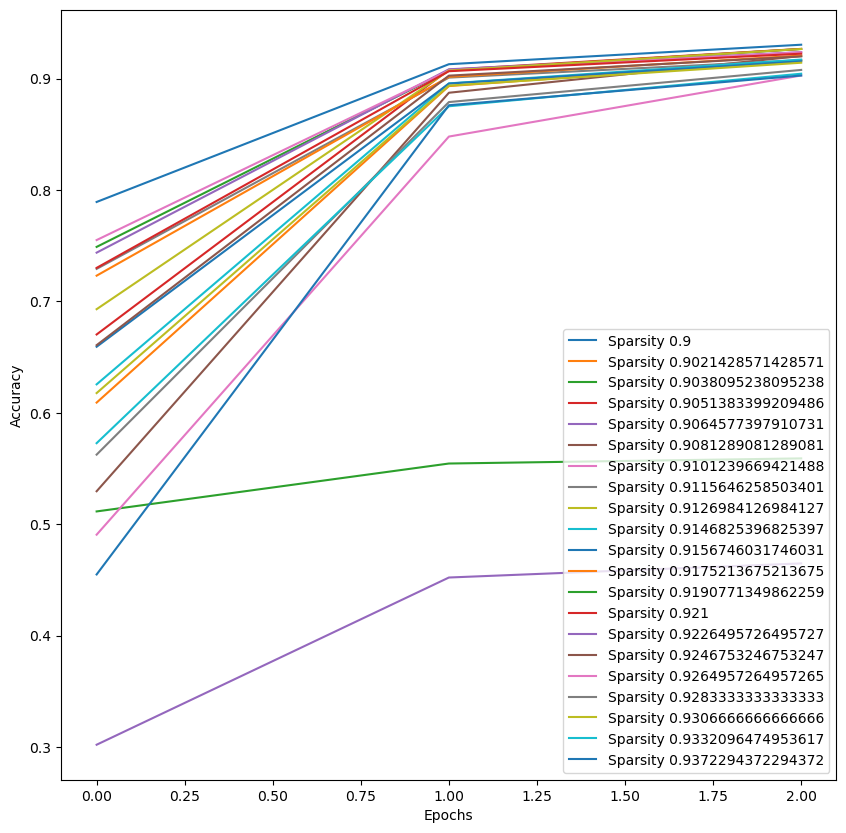

In [9]:
epochs_range = range(epochs)
plt.figure(figsize=(10, 10))
for i, history in enumerate(histories):
    acc = history.history['accuracy']
    
    plt.plot(epochs_range, acc, label='Sparsity '+str(sparsities[i]))
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
    
plt.show()

313/313 [==============================] - 0s 958us/step - loss: 0.3129 - accuracy: 0.9131


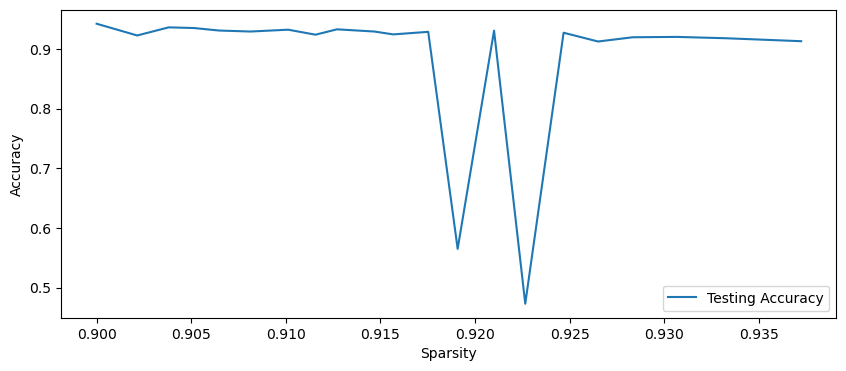

In [10]:
accuracies = []
for model in models:
    accuracies.append(model.evaluate(X_test, Y_test)[1])
plt.figure(figsize=(10, 4))
plt.plot(sparsities, accuracies, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.show()

### Set seed

In [36]:
histories = []
accuracies = []
seeds = list(range(1000,10001,1000))
for seed in seeds:
    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()
    np.random.seed(seed)
    
    #model = createModel(0,greater90[sparsities[12]])
    model = createModel(0,greater90[sparsities[0]])
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    epochs = 10
    history = model.fit(X_train,Y_train,epochs = epochs, batch_size = 2048,validation_split = 0.1, verbose = 0)
    histories.append(history)
    accuracies.append(model.evaluate(X_test,Y_test)[1])
    

313/313 [==============================] - 0s 946us/step - loss: 0.3666 - accuracy: 0.9024


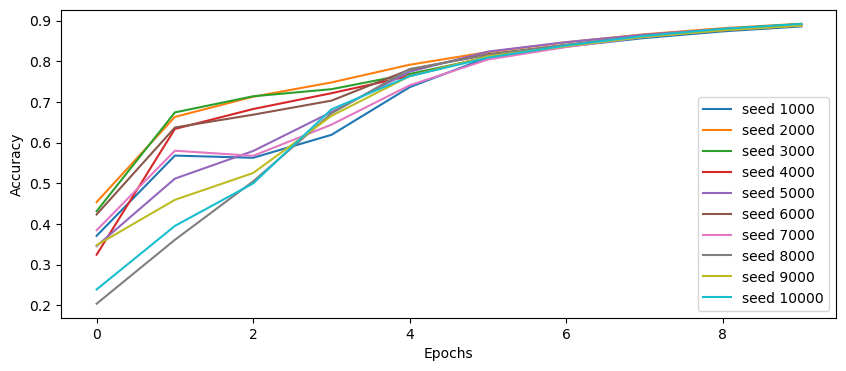

In [37]:
epochs_range = range(epochs)
plt.figure(figsize=(10, 4))
for i, history in enumerate(histories):
    acc = history.history['accuracy']
    
    plt.plot(epochs_range, acc, label='seed '+str(seeds[i]))
plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
    
plt.show()

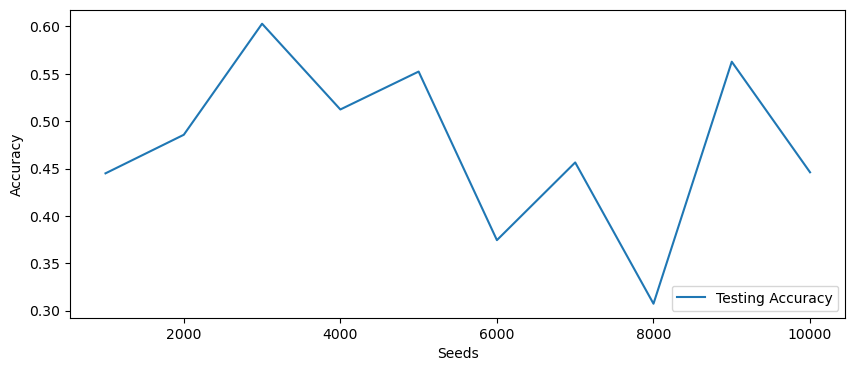

In [35]:
plt.figure(figsize=(10, 4))
plt.plot(seeds, accuracies, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Seeds")
plt.ylabel("Accuracy")
plt.show()